# CPSC 330 - Applied Machine Learning 

## Homework 7: Clustering and recommender systems
### Associated lectures: Lectures 14 and 15

**Due date: Monday, March 21, 11:59pm**


In [1]:
import os

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.cluster import DBSCAN, KMeans
from sklearn.feature_extraction.text import CountVectorizer

pd.set_option("display.max_colwidth", 0)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

<br><br><br><br>

## Instructions 
<hr>
rubric={points:2}

Follow the [homework submission instructions](https://github.com/UBC-CS/cpsc330-2022W2/blob/main/docs/homework_instructions.md). 

**You may work on this homework in a group and submit your assignment as a group.** Below are some instructions on working as a group.  
- The maximum group size is 2. 
- Use group work as an opportunity to collaborate and learn new things from each other. 
- Be respectful to each other and make sure you understand all the concepts in the assignment well. 
- It's your responsibility to make sure that the assignment is submitted by one of the group members before the deadline. 
- You can find the instructions on how to do group submission on Gradescope [here](https://help.gradescope.com/article/m5qz2xsnjy-student-add-group-members).

<br><br><br><br>

## Exercise 1: Document clustering toy example <a name="1"></a>
<hr>

In lecture 14, we looked at a popular application of clustering: customer segmentation. In this homework, we will work on a toy example of another popular application: [**document clustering**](https://en.wikipedia.org/wiki/Document_clustering). A large amount of unlabeled text data is available out there (e.g., news, recipes, online Q&A), and clustering is a commonly used technique to organize this data in a meaningful way. 

In this exercise, we will create a toy dataset with sentences from Wikipedia articles and cluster these sentences. 

### 1.1 Sample sentences from Wikipedia articles
rubric={points:2}

The code below extracts first sentences of Wikipedia articles on a set of queries. You will need the `wikipedia` package installed in the course environment to run the code below. 

```
conda activate cpsc330
conda install -c conda-forge wikipedia
```

You also need `nltk` library in the course environment. 

```
conda install -c anaconda nltk 
```        

**Your tasks:**

Run the code below and answer the following question. 

1. Given this dataset, how many clusters would you expect a clustering algorithm to identify? How would you manually label these clusters?   

> *Note: Feel free to experiment with queries of your choice. But stick to the provided list for the final submission so that it's easier for the TAs when they grade your submission.*


In [2]:
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
nltk.download("punkt")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\lucam\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
import wikipedia

queries = [
    "Mount Everests",
    "Raspberry",
    "Mount Denali",
    "Arithmetic",
    "Topology",
    "Baseball",
    "Hockey",
    "Mango_fruit",
    "Mount Kenya",
    "Football"
]

wiki_dict = {"wiki query": [], "text": [], "n_words": []}
for i in range(len(queries)):
    sent = sent_tokenize(wikipedia.page(queries[i]).content)[0]
    wiki_dict["text"].append(sent)
    wiki_dict["n_words"].append(len(word_tokenize(sent)))
    wiki_dict["wiki query"].append(queries[i])

wiki_df = pd.DataFrame(wiki_dict)
wiki_df

,wiki query,text,n_words
0,Mount Everests,"Mount Everest (Nepali: सगरमाथा, romanized: Sagarmāthā; Tibetan: Chomolungma ཇོ་མོ་གླང་མ; Chinese: 珠穆朗玛峰; pinyin: Zhūmùlǎngmǎ Fēng) is Earth's highest mountain above sea level, located in the Mahalangur Himal sub-range of the Himalayas.",44
1,Raspberry,"The raspberry is the edible fruit of a multitude of plant species in the genus Rubus of the rose family, most of which are in the subgenus Idaeobatus.",30
2,Mount Denali,"Denali (; also known as Mount McKinley, its former official name) is the highest mountain peak in North America, with a summit elevation of 20,310 feet (6,190 m) above sea level.",38
3,Arithmetic,"Arithmetic (from Ancient Greek ἀριθμός (arithmós) 'number', and τική [τέχνη] (tikḗ [tékhnē]) 'art, craft') is an elementary part of mathematics that consists of the study of the properties of the traditional operations on numbers—addition, subtraction, multiplication, division, exponentiation, and extraction of roots.",62
4,Topology,"In mathematics, topology (from the Greek words τόπος, 'place, location', and λόγος, 'study') is concerned with the properties of a geometric object that are preserved under continuous deformations, such as stretching, twisting, crumpling, and bending; that is, without closing holes, opening holes, tearing, gluing, or passing through itself.",68
5,Baseball,"Basketball is a team sport in which two teams, most commonly of five players each, opposing one another on a rectangular court, compete with the primary objective of shooting a basketball (approximately 9.4 inches (24 cm) in diameter) through the defender's hoop (a basket 18 inches (46 cm) in diameter mounted 10 feet (3.048 m) high to a backboard at each end of the court), while preventing the opposing team from shooting through their own hoop.",92
6,Hockey,"Hockey is a term used to denote a family of various types of both summer and winter team sports which originated on either an outdoor field, sheet of ice, or dry floor such as in a gymnasium.",40
7,Mango_fruit,A mango is an edible stone fruit produced by the tropical tree Mangifera indica.,15
8,Mount Kenya,"Mount Kenya (Kikuyu: Kĩrĩnyaga, Kamba, Ki Nyaa) is the highest mountain in Kenya and the second-highest in Africa, after Kilimanjaro.",27
9,Football,"Football is a family of team sports that involve, to varying degrees, kicking a ball to score a goal.",22


It can be a bit difficult to predict how many clusters a clustering algorithm predict depending on the dataset. Given the relatively small size of this dataset I was able to identify a cluster of sports (Baseball, Hockey, and Football), a cluster of mountains (Mt Everest, Mt Denali, Mt Kenya), a cluster of Fruits (Raspberry, Mango_fruit) and a cluster of math stuff (Arithmetic, Topology). This gives a total of 4 clusters for a clustering algorithm to identify.

<br><br>

### 1.2 `KMeans` with bag-of-words representation 
rubric={points:10}

We have seen that before we pass text to machine learning models, we need to encode it into a numeric representation. So let's encode our toy dataset above (`wiki_df`) to a numeric representation. 

First, let's try our good old friend: bag-of-words representation. The code below creates dense bag-of-words representation of Wikipedia sentences from question 1.1 using a [`CountVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html). 

**Your tasks:**

Run the code below and answer the following questions. 

1. Run `KMeans` clustering on the transformed data (`bow_sents`) with K = the number of clusters you identified in question 1.1. Examine clustering labels assigned by `KMeans`.
2. Repeat after modifying the `CountVectorizer` to ignore words appearing in only one sentence (or document, one row of `wiki_df`).
3. Keeping the new `CountVectorizer`, examine clustering labels assigned by `KMeans` under an off-by-1 value of K.
4. Briefly describe and analyze the behavoir of `KMeans`. Is `KMeans` doing a reasonable job in clustering the sentences? 

> You can access cluster label assignments using `labels_` attribute of the clustering object. 

In [4]:
vec = CountVectorizer(stop_words='english')
bow_sents = vec.fit_transform(wiki_df["text"]).todense()
bow_df = pd.DataFrame(
    data=bow_sents, columns=vec.get_feature_names_out(), index=wiki_df.index
)


In [5]:
kmeans = KMeans(n_clusters = 4)
kmeans.fit(bow_sents)
kmeans.labels_

C:\Users\lucam\miniconda3\envs\cpsc330\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


array([1, 1, 1, 0, 3, 2, 1, 1, 1, 1])

In [6]:
vec = CountVectorizer(stop_words = "english", min_df = 2)
bow_sents = vec.fit_transform(wiki_df["text"]).todense()
bow_df = pd.DataFrame(
    data=bow_sents, columns=vec.get_feature_names_out(), index=wiki_df.index
)

kmeans = KMeans(n_clusters = 4)
kmeans.fit(bow_sents)
kmeans.labels_

C:\Users\lucam\miniconda3\envs\cpsc330\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


array([2, 3, 2, 0, 0, 1, 1, 3, 2, 1])

KMeans does a great job when you ignore the words that appear only once in a document. It was able to succesfully cluster all the different categories into the clusters that I had defined early. However, without some text preprocessing KMeans is not able to successfully cluster the queries. 

### 1.3 Sentence embedding representation
rubric={points:10}

Bag-of-words representation is limited in that it does not take into account word ordering and context. There are other richer representations of text, and we are going to use one such representation in this lab. 

The code below creates an alternative and a more expressive representation of sentences. We will call it *sentence embedding representation*. We'll use [sentence transformer](https://www.sbert.net/index.html) to extract these representations. At this point it's enough to know that this is an alternative representation of text which usually works better than simple bag-of-words representation. We will talk a bit more about embedding representations next week. You need to install `sentence-transformers` in the course conda environment to run the code below. 

```conda install -c conda-forge sentence-transformers```

**Your tasks:**

Run the code below and answer the following questions. 

1. How many dimensions (features associated with each example) are present in this representation? 
2. Run `KMeans` clustering with sentence embedding representation of text (`emb_sents`) and examine cluster labels. 
3. How well the sentences are clustered together? 

In [7]:
from sentence_transformers import SentenceTransformer

embedder = SentenceTransformer("paraphrase-distilroberta-base-v1")

In [8]:
emb_sents = embedder.encode(wiki_df["text"])
emb_sent_df = pd.DataFrame(emb_sents, index=wiki_df.index)
emb_sent_df

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,-0.532167,0.219127,0.029920,-0.407121,-0.616050,0.339105,-0.369831,-0.268620,0.284335,0.154874,...,0.049629,-0.063531,0.193070,0.345019,0.111517,-0.018490,0.062622,-0.105441,0.084189,0.097068
1,-0.257144,0.279162,0.222628,0.190509,0.057312,0.215432,0.124739,0.256541,-0.093520,0.304061,...,-0.350747,-0.103448,0.188898,0.002680,0.364524,0.270560,0.617305,0.565283,0.068011,0.210108
2,-0.153511,0.308003,0.042989,-0.000983,-0.228808,0.145076,-0.189960,0.006522,0.346580,0.009805,...,0.345482,0.149473,-0.128204,0.069987,-0.049316,-0.122242,-0.520354,0.052404,0.277886,-0.082411
3,-0.182559,0.174978,-0.142932,0.508398,-0.102793,0.314822,-0.028197,0.235509,0.293719,0.091493,...,0.153091,-0.220330,0.126606,0.091785,0.087272,0.279831,-0.328508,0.157603,0.439282,0.204193
4,0.002731,0.032420,0.043655,0.501372,0.442546,0.157427,0.082318,0.287892,0.322356,0.356958,...,0.267656,-0.337920,0.343272,0.429253,-0.042079,0.466611,-0.574507,0.004958,0.390041,0.150982
5,-0.042878,0.029167,-0.187499,-0.020230,-0.260429,-0.120475,0.067831,0.296154,-0.020178,0.003125,...,0.178185,-0.003942,0.331447,-0.395468,0.025013,0.082307,-0.561699,0.560588,0.141633,-0.373938
6,-0.071380,0.096587,0.055705,-0.525645,0.580350,0.096592,0.441485,0.257062,-0.054260,0.220842,...,0.457613,-0.331446,-0.066380,-0.019426,-0.147649,0.034530,-0.095109,0.304423,0.327636,-0.197770
7,-0.141320,0.030475,0.261100,-0.219024,-0.277812,0.177240,0.191266,0.252725,-0.035201,0.198338,...,0.104466,-0.177959,0.088619,0.289035,-0.089657,0.246049,-0.060229,0.500508,-0.045897,-0.046336
8,-0.291509,0.554150,0.115631,-0.188635,-0.074476,-0.277101,-0.000275,0.076825,0.199134,0.033997,...,0.055575,0.047854,0.214838,-0.086142,0.453633,0.021888,-0.143639,0.167839,-0.151438,-0.076444
9,-0.071756,0.133156,-0.071762,0.306060,0.358961,-0.061443,0.167585,0.364614,0.323540,0.141398,...,0.404115,0.000236,0.177493,0.016162,0.232335,0.260556,0.168149,0.483963,0.121122,0.196881


In [9]:
kmeans.fit(emb_sents)
kmeans.labels_

C:\Users\lucam\miniconda3\envs\cpsc330\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


array([1, 3, 1, 2, 2, 0, 0, 3, 1, 0])

KMeans with sentence embedding representation can also accurately cluster the different queries as it placed the respective queries into the groups I defined earlier. 

### 1.4 DBSCAN with cosine distance  
rubric={points:10}

Let's try `DBSCAN` on our toy dataset. K-Means is kind of bound to the Euclidean distance because it is based on the notion of means. With `DBSCAN` we can try different distance metrics. In the context of text (sparse data), [cosine similarities](https://scikit-learn.org/stable/modules/metrics.html#cosine-similarity) or cosine distances tend to work better. Given vectors $u$ and $v$, the **cosine distance** between the vectors is defined as: 

$$distance_{cosine}(u,v) = 1 - (\frac{u \cdot v}{\left\lVert u\right\rVert_2 \left\lVert v\right\rVert_2})$$

In this exercise, you'll use DBSCAN with cosine distances. 

**Your tasks**

1. Use DBSCAN to cluster our toy data using sentence embedding representation (`emb_sents`) and `metric='cosine'`. 
2. Briefly comment on the number of clusters identified and the cluster assignment given by the algorithm.

> *Note: You will also have to set appropriate values for the hyperparamters `eps` and `min_samples` to get meaningful clusters, as default values for these hyperparameters won't work on this toy dataset. In order to set appropriate value for `eps`, you may want to examine the distances given by [sklearn's `cosine_distance`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.paired_cosine_distances.html).*

In [10]:
dbscan = DBSCAN(metric = 'cosine', eps = .6, min_samples = 2)
dbscan.fit(emb_sents)
dbscan.labels_

array([0, 1, 0, 2, 2, 3, 3, 1, 0, 3], dtype=int64)

In [11]:
from sklearn.metrics import pairwise_distances


In [12]:
pd.DataFrame(pairwise_distances(emb_sents, emb_sents, metric = 'cosine'))

,0,1,2,3,4,5,6,7,8,9
0,0.000000,0.931335,0.424351,0.827909,0.870119,0.925508,0.951119,0.841844,0.409439,0.991959
1,0.931335,0.000000,0.906466,0.847008,0.864610,0.869627,0.903234,0.522127,0.898711,0.839252
2,0.424351,0.906466,0.000000,0.907096,0.854794,0.856469,0.815634,0.853448,0.456956,0.904455
3,0.827909,0.847008,0.907096,0.000000,0.381103,0.772545,0.812594,0.902332,0.889986,0.816896
4,0.870119,0.864610,0.854794,0.381103,0.000000,0.755116,0.753566,0.842974,0.955045,0.792475
5,0.925508,0.869627,0.856469,0.772545,0.755116,0.000000,0.596294,0.951435,0.831017,0.528304
6,0.951119,0.903234,0.815634,0.812594,0.753566,0.596294,0.000000,0.916049,0.954532,0.526190
7,0.841844,0.522127,0.853448,0.902332,0.842974,0.951435,0.916049,0.000000,0.806186,0.845019
8,0.409439,0.898711,0.456956,0.889986,0.955045,0.831017,0.954532,0.806186,0.000000,0.938583
9,0.991959,0.839252,0.904455,0.816896,0.792475,0.528304,0.526190,0.845019,0.938583,0.000000


After tuning the hyperparameters the DBMS algorithm was able to identify 4 clusters. The DBMS algorithm was also able to accurately place all the queries into their respective clusters that I defined earlier.

### 1.5 Visualizing clusters 
rubric={points:5}

One thing we could do with unlabeled data is visualizing it. That said, our data is high dimensional (each example is represented with 768 dimensions) and high-dimensional data is hard to visualize. One way to visualize high-dimensional data is applying dimensionality reduction to get the most important (2 or 3) components of the dataset and visualizing this low-dimensional data. 

Given data as a `numpy` array and cluster assignments, the `plot_pca_clusters` function below transforms the given data by applying dimensionality reduction and plots the transformed data into corresponding clusters. 

> *Note: At this point we are using this function only for visualization and you are not expected to understand the PCA part. Feel free to modify the function as you see fit.*

**Your tasks:**

1. Call the function `plot_pca_clusters` to visualize the clusters created by the three models above:
    - KMeans with bag-of-words representation 
    - KMeans with sentence embedding representation 
    - DBSCAN with sentence embedding representation 

In [13]:
from sklearn.decomposition import PCA # Obtain the principal components

def plot_pca_clusters(
    data,
    cluster_labels,
    raw_sents=wiki_df["text"],
    show_labels=False,
    size=100,
    title="PCA visualization",
):
    """
    Carry out dimensionality reduction using PCA and plot 2-dimensional clusters.

    Parameters
    -----------
    data : numpy array
        data as a numpy array
    cluster_labels : list
        cluster labels for each row in the dataset
    raw_sents : list
        the original raw sentences for labeling datapoints
    show_labels : boolean
        whether you want to show labels for points or not (default: False)
    size : int
        size of points in the scatterplot
    title : str
        title for the visualization plot

    Returns
    -----------
    None. Shows the clusters.
    """

    pca = PCA(n_components=2)
    principal_comp = pca.fit_transform(data)
    pca_df = pd.DataFrame(data=principal_comp, columns=["pca1", "pca2"])
    pca_df["cluster"] = cluster_labels

    plt.figure(figsize=(10, 7))
    plt.title(title)
    ax = sns.scatterplot(
        x="pca1", y="pca2", hue="cluster", data=pca_df, palette="tab10", s=size
    )

    x = pca_df["pca1"].tolist()
    y = pca_df["pca2"].tolist()
    if show_labels:
        for i, txt in enumerate(raw_sents):
            plt.annotate(" ".join(txt.split()[:10]), (x[i], y[i]))
        ax.legend(loc="upper right")

    plt.show()

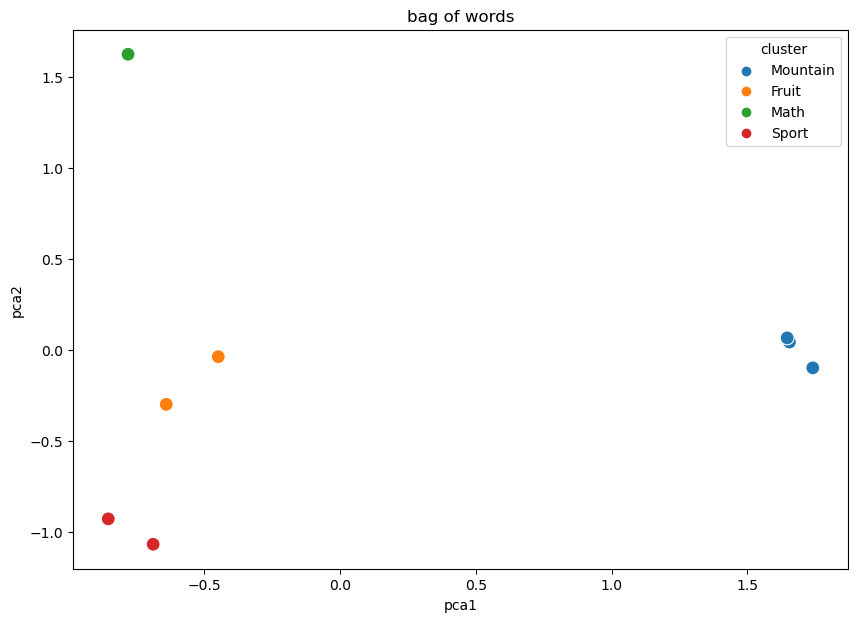

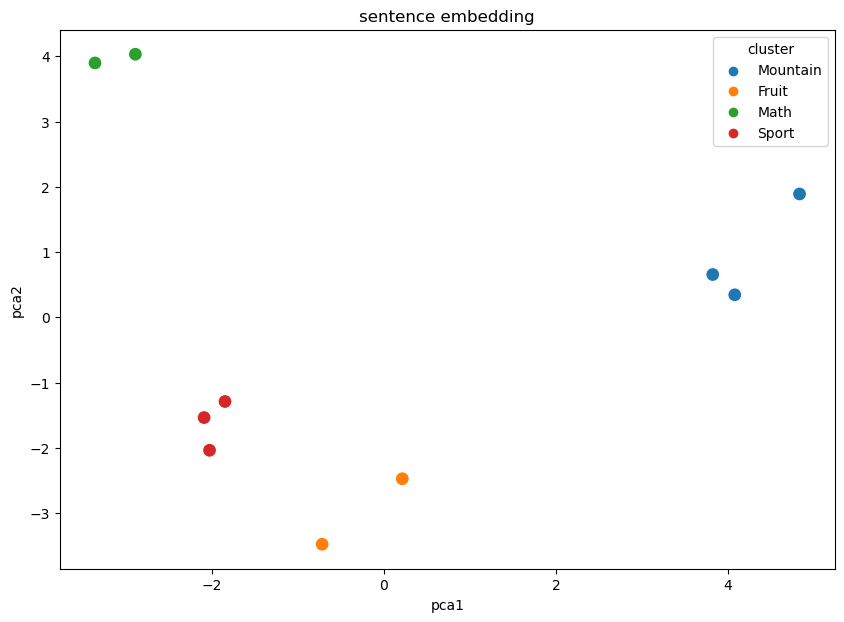

In [14]:
Clusters = ["Mountain", "Fruit", "Mountain", "Math", "Math", "Sport", "Sport", "Fruit", "Mountain", "Sport"]


data = [bow_df.values, emb_sent_df.values]


plot_pca_clusters(bow_df.values, Clusters, title = "bag of words")
plot_pca_clusters(emb_sent_df.values, Clusters, title = "sentence embedding")
    

<br><br><br><br>

## Exercise 2: Movie recommendations
<hr>

Let's build simple movie recommendation systems using the [MovieLens dataset](https://www.kaggle.com/prajitdatta/movielens-100k-dataset/data). The original source of the data is [here](https://grouplens.org/datasets/movielens/), and the structure of the data is described in the [README](http://files.grouplens.org/datasets/movielens/ml-latest-small-README.html) that comes with it. The code below reads the data as a CSV assuming that it's under `data/ml-100k/` directory under your lab folder. 

In [15]:
r_cols = ["user_id", "movie_id", "rating", "timestamp"]
ratings = pd.read_csv(
    os.path.join("data", "ml-100k", "u.data"),
    sep="\t",
    names=r_cols,
    encoding="latin-1",
)
ratings.head()


,user_id,movie_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [16]:
# We'll be using these keys later in the starter code
user_key = "user_id"
item_key = "movie_id"

### 2.1 Terminology
rubric={points:6}

Here is some notation we will be using in this lab. 

**Constants**:

 - $N$: the number of users, indexed by $n$
 - $M$: the number of movies, indexed by $m$
 - $\mathcal{R}$: the set of indices $(n,m)$ where we have ratings in the utility matrix $Y$
    - Thus $|\mathcal{R}|$ is the total number of ratings
 - $k$: the number of latent dimensions we use in collaborative filtering
 
**The data**:

 - $Y$: the utility matrix containing ratings, with a lot of missing entries
 - $Z$: a matrix whose rows $z_m$ represent the features for movie $m$ (size $M\times d$).
 - `train_mat` and `valid_mat`: Utility matrices for train and validation sets, respectively
 
    
**Your tasks:**    

1. What are the values of $N$ and $M$ in movie ratings data?  
2. What would be the shape of the dense utility matrix $Y$? 
3. What would be the fraction of observed ratings in the utility matrix $Y$? 

In [17]:
N = len(np.unique(ratings[user_key]))
M = len(np.unique(ratings[item_key]))
len(ratings)/(N*M)

0.06304669364224531

1. The value of N is 943 and the value of M is 1682
2. The shape of the dense utility Matrix is 943 x 1682
3. Th fraction of observed ratings in the utility matrix would be: 100000 / (943 * 1682) = 0.063

<br><br>

### 2.2 Splitting the data
rubric={points:5}

**Your tasks:**

1. Split the ratings data with `test_size=0.2` and `random_state=42`. 

In [18]:
from sklearn.model_selection import train_test_split
X = ratings.copy()
y = ratings[user_key]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

<br><br>

### 2.3 Utility matrix 
rubric={points:10}

**Your tasks**
1. Create utility matrices for train and validation sets (similar to how we did in the class). 
2. Briefly explain the difference between the train and validation utility matrices. 

> You may use the code from lecture notes with appropriate attributions.  

> You won't do it in real life but since our dataset is not that big, create a dense utility matrix in this assignment. You are welcome to try sparse matrix but then you may have to change some started code provided in the later exercises.  

In [19]:
user_mapper = dict(zip(np.unique(ratings[user_key]), list(range(N))))
item_mapper = dict(zip(np.unique(ratings[item_key]), list(range(M))))
user_inverse_mapper = dict(zip(list(range(N)), np.unique(ratings[user_key])))
item_inverse_mapper = dict(zip(list(range(M)), np.unique(ratings[item_key])))

#Code adapted from lecture 16
def create_Y_from_ratings(
    data, N, M, user_mapper, item_mapper, user_key="user_id", item_key="movie_id"
):  # Function to create a dense utility matrix
    Y = np.zeros((N, M))
    Y.fill(np.nan)
    for index, val in data.iterrows():
        n = user_mapper[val[user_key]]
        m = item_mapper[val[item_key]]
        Y[n, m] = val["rating"]

    return Y

In [20]:
train_mat = create_Y_from_ratings(X_train, N, M, user_mapper, item_mapper)
valid_mat = create_Y_from_ratings(X_test, N, M, user_mapper, item_mapper)

The train matrix contains ratings from X_train while the validation matrix only contains only ratings from X_test. Both have the same shape since they are constructed from the same utility matrix.

<br><br>

### 2.4 Evaluation and baseline
rubric={points:4}

To compare different models you build in this homework, let's write a couple of functions for evaluation. 
- The `error` function returns RMSE.
- The `evaluate` function prints the train and validation RMSEs. 

**Your task:**

1. Briefly explain what exactly we are comparing to evaluate recommender systems. 
2. Implement the global average baseline, where you predict everything as the global average rating. What's the RMSE of the global average baseline?

In [21]:
def error(Y1, Y2):
    """
    Returns the root mean squared error (RMSE).
    """
    return np.sqrt(np.nanmean((Y1 - Y2) ** 2))


def evaluate(pred_Y, train_mat, valid_mat, model_name="Global average"):
    print("%s train RMSE: %0.2f" % (model_name, error(pred_Y, train_mat)))
    print("%s valid RMSE: %0.2f" % (model_name, error(pred_Y, valid_mat)))

In [22]:
#Code adapted from lecture 
avg = np.nanmean(train_mat)
pred_g = np.zeros(train_mat.shape) + avg

evaluate(pred_g, train_mat, valid_mat, model_name="Global average")

Global average train RMSE: 1.13
Global average valid RMSE: 1.12


1. We are comparing the error between actual ratings and predicted ratings using the RMSE metric.
2. The RMSE of the global average baseline is 1.12

<br><br>

### (Optional) 2.5 $k$-nearest neighbours imputation
rubric={points:1}

**Your tasks:**

Try [KNNImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.KNNImputer.html) to fill in the missing entries. Discuss your observations. 

In [23]:
from sklearn.impute import KNNImputer

train_mat_copy = np.copy(train_mat)

imputer = KNNImputer(n_neighbors=10, copy = False)
imputer.fit_transform(train_mat_copy)


array([[4. , 3. , 4. , ..., 3. , 2. , 3. ],
       [4. , 3. , 3.3, ..., 3. , 2. , 3. ],
       [3.8, 3.2, 2.8, ..., 3. , 2. , 3. ],
       ...,
       [5. , 3.4, 2.9, ..., 3. , 2. , 3. ],
       [4.2, 3.4, 3.6, ..., 3. , 2. , 3. ],
       [4.3, 5. , 3.2, ..., 3. , 2. , 3. ]])

In [24]:
evaluate(train_mat_copy, train_mat, valid_mat, model_name="KNN imputer")

KNN imputer train RMSE: 0.00
KNN imputer valid RMSE: 0.98


The KNN imputer is preforming better than the global average baseline. It is also performing similarly to the SVD algorithm although slightly worse. 

### 2.6 Use collaborative filtering with the `surprise` package
rubric={points:6}

Use the [`surprise`](https://surprise.readthedocs.io/en/stable/) package which has implementation of SVD algorithm for collaborative filtering. You can install it as follows in your conda environment. 

```
>> conda activate cpsc330
>> conda install -c conda-forge scikit-surprise
or 
>> pip install scikit-surprise
```

**Your tasks:**

1. Carry out cross-validation using SVD algorithm in the package, similar to how we did it in the lecture on Jester dataset. Report mean RMSE and compare it with global baseline. 

In [25]:
import surprise
from surprise import SVD, Dataset, Reader, accuracy
from surprise.model_selection import cross_validate

In [26]:
reader = Reader()
rating_data = ratings.drop(columns = ['timestamp'])
data = Dataset.load_from_df(rating_data, reader)

trainset, validset = surprise.model_selection.train_test_split(
    data, test_size=0.2, random_state=42
)

k = 5
svd_alg = SVD(n_factors=k, random_state=42)
svd_alg.fit(trainset)


pd.DataFrame(cross_validate(svd_alg, data, measures=["RMSE"], cv=5, verbose=True))

Evaluating RMSE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9373  0.9318  0.9337  0.9388  0.9382  0.9360  0.0027  
Fit time          0.57    0.57    0.57    0.59    0.57    0.57    0.01    
Test time         0.15    0.28    0.13    0.14    0.14    0.17    0.05    


,test_rmse,fit_time,test_time
0,0.937298,0.567158,0.152903
1,0.931844,0.566231,0.275445
2,0.933708,0.572086,0.127540
3,0.938805,0.593400,0.143095
4,0.938198,0.573206,0.137213


The Mean RMSE is .9360 which is improved from the global baseline of 1.12 

<br><br>

### 2.7 Clustering based recommendation system?
rubric={points:2}

How would you apply `K-Means` clustering to build a recommendation systems? What could be challenging with this approach?

You can apply K-Means clustering to build a recommendation system. First you can group similar items based on their features. Based on a users preferences for an item you can recommend other items that are in the same group/cluster. Since K-Means requires you to specify the number of clusters in advance, choosing the right K could be quite difficult. Also a recommendation using K-Means would be unlikely to recommend any novel items as the the K-Means algorithm would not recommend items that may fall outside of a cluster. This challenge of recommending novel items is exacerbated by the fact that an item can only belong to one cluster when in reality there is often meaningful overlap between two or more different clusters. 

<br><br><br><br>

## Submission instructions 

**PLEASE READ:** When you are ready to submit your assignment do the following:

1. Run all cells in your notebook to make sure there are no errors by doing `Kernel -> Restart Kernel and Clear All Outputs` and then `Run -> Run All Cells`. 
2. Notebooks with cell execution numbers out of order or not starting from “1” will have marks deducted. Notebooks without the output displayed may not be graded at all (because we need to see the output in order to grade your work).
3. Upload the assignment using Gradescope's drag and drop tool. Check out this [Gradescope Student Guide](https://lthub.ubc.ca/guides/gradescope-student-guide/) if you need help with Gradescope submission. 